# Further Closure:  
## A final project on simulating something "like electrons and positrons"

## Objectives:

* Gain familiarity with simulating quantum systems through trotterization
* Using all your accrued skills, implement a novel code on a real device
* Perform statistical analysis on noisy data

This lab is a vain attempt to extend some of the work performed in BLARG to actual machines. I have tried to inject this with as much of the real feel of doing work on quantum algorithms today as possible.  

## The Model: 1+1d $Z_2$ gauge theory with staggered fermionic matter

To remember the picture, and the qubit assignments
![z2_cart.png](attachment:z2_cart.png)

## The Hamiltonian

The lattice qubit Hamiltonian for this model is

$$
H = \frac{m}{2}Z_{e}-\frac{m}{2} Z_{p}
+X_{\gamma}+\frac{1}{4}Z_{\gamma} \left(X_{e}X_{p}+Y_e Y_{p}\right)
$$

The subscripts indicate which of the 3 qubits a given gate is acting on (the electron $e$, the positron $p$, or the photon $\gamma$)

## Time Evolution

$$ |\psi(t)\rangle = U|\psi_0\rangle=e^{-iHt}|\psi_0\rangle$$

Thinking back to Hersh's lecture, we remember that $H$ often has non-commuting terms, which prevents the gate $U$ from being efficiently built into a circuit.  The method of _trotterization_ allows us approximate the $U$ in a way that is efficient.  In our case, there are 3 terms in our Hamiltonian:

$$ H = H_{kg} + H_{fh} + H_{m} $$

* $H_{kg}$ is the kinetic term for the photon
* $H_{fh}$ is the fermionic hopping term
* $H_{m}$ is the fermionic mass terms

In this case, we can approximate $U$ by:

$$\Large U=e^{-iHt}\approx \left(e^{-iH_{kg}\epsilon}e^{-iH_{fh}\epsilon}e^{-iH_{m}\epsilon}\right)^{t/\epsilon}+O(\epsilon^2)\equiv (U_\epsilon)^{N} $$
where $N=t/\epsilon$ is the number of time steps we want to use. With this, we can now write $U_\epsilon$ in terms of gates:

$$\Large{ U_{\epsilon}=e^{-iH_{kg}\epsilon}e^{-iH_{fh}\epsilon}e^{-iH_{m}\epsilon}
\\     =e^{-i\epsilon X_\gamma}e^{-i\frac{\epsilon}{4}Z_{\gamma} \left(X_{e}X_{p}+Y_e Y_{p}\right)}e^{-i(-1)^j m \epsilon Z_j} }$$
where $j={e=0,p=1}$
Now, the first and last gates should look familar to you as general rotation gates in the $X,Z$ directions:

$${ e^{-i\epsilon X_\gamma}=RX(-\epsilon/2)
    \\e^{-i(-1)^j m \epsilon Z_j}=RZ((-1)^{j+1}m\epsilon ) } $$

The final term, fermion hopping $U_{fh}$, is by far the hardest and most non-trivial gate.  Previously, you implemented a 4 qubit gate for performing this by defining a gate $RZ3$ as the collection of CNOTs and the $RZ$ gate, this gate looks like:

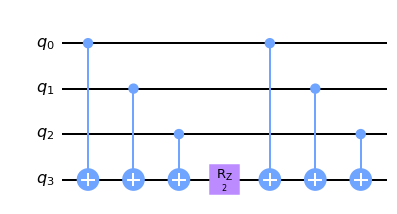

from which we can get the $U_{fh}$ as:

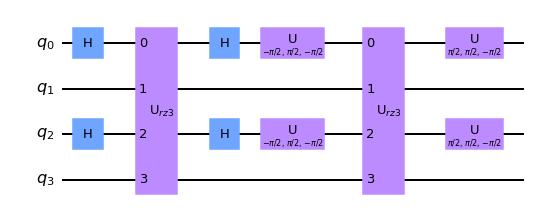

Notice that this gate requires 12 $CNOTs$.  Since 2-qubit gates errors are much larger than 1 qubit errors, the errors in $U_{fh}$ dominate our circuit.

We will come back to this.


## ...Ready for it? 

So first of, lets of course set up all the imports that we need:

* numpy
* import everything from qiskit
* import `matplotlib.pyplot` as plt
* Make sure you have $\pi$

In [1]:
import numpy as np
from qiskit import IBMQ, Aer, assemble, transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from numpy import pi

Next, you neeed to load your IBMQ account, and set your provider to our `qjs-for-hep` project.  Finally, use the command

    provider.backends()
to look at all the computers 'available' to you (Note, 'ibmq_16_melbourne' isn't actually accessible)

Keep this list for later

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')>,
 <IBMQBackend('ibmq

Copy over from yesterday your initalization of `N,epsilon`, and `mass`

In [9]:
N = 2
epsilon = 0.5
m = 0.10
eta = 1

## Gauge Kinetic Gate
Copy over your function for $RX(-\epsilon/2)$

In [4]:
def gauge_kinetic(epsilon):
    qc = QuantumCircuit(1)
    theta = -epsilon/2
    qc.rx(theta, 0)
    ukg = qc.to_gate()
    ukg.name = 'Rx'
    
    return ukg

## Fermion mass gate

Copy over your function for $RZ((-1)^{j+1}m\epsilon ) $

In [5]:
def fermion_mass(epsilon, mass, eta):
    qc = QuantumCircuit(1)
    qc.rz((-eta*mass*epsilon), [0])
    fm = qc.to_gate()
    fm.name = "Rz"
    return fm

## Fermion hopping term

Copy over your functions for $RZ3$ and $U_{fh}$

In [6]:
def rz3(theta):
    qc = QuantumCircuit(4)
    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)
    qc.rz(theta, 3)
    qc.cx(0,3)
    qc.cx(1,3)
    qc.cx(2,3)
    U_rz3 = qc.to_gate()
    U_rz3.name = "the complicated set of gates (urz3)"
    return U_rz3

In [7]:
def gross_gate(epsilon, eta):
    qc = QuantumCircuit(4)
    qc.h(0)
    qc.h(2)
    qubit_list = [0,1,2,3]
    U_rz3 = rz3((-epsilon)/(4*eta))
    qc.append(U_rz3, qubit_list)
    qc.h(0)
    qc.h(2)
    qc.u((-pi/2), (pi/2), (-pi/2), 0)
    qc.u((-pi/2), (pi/2), (-pi/2), 2)
    qc.append(U_rz3, qubit_list)
    qc.u((pi/2), (pi/2), (-pi/2), 0)
    qc.u((pi/2), (pi/2), (-pi/2), 2)
    grossgate = qc.to_gate()
    grossgate.name = "ufh"
    return grossgate

Clearly, $U_{fh}$ is much more expensive to implement than the $U_{kg}$ or $U_{fm}$. Last time, you performed benchmarking using the state $|0000\rangle$.  In the musings at the end of the lab, I asked you to ponder whether this was sufficient to learn everything about the circuit.  One thing you might have worried about is that, if we only pass in 1 state, perhaps the biggest errors happen for other states.  This is precisely what we will test now.

* To do this, create a QuantumCircuit with 4 qubits and 4 classical bits, apply your fermion_hopping gate with `epsilon` and `eta=1`.
* Initialize the first 3 qubits into Hadamard states.
* Run and get the counts output from the `qasm_simulator` as your backend with `Aer.get_backend()`.  Store the counts of your result in `sim_results`
* Rerun with a real device, store the counts of your results in `real_results`
*Because changing machines can change the noise dramatically, instead of using `least_busy` you should choose a single backend from the list above with the command `backend = provider.get_backend('name_of_backend')`. Because we need 4 qubits, you should only choose from: `ibmq_belem`, `ibmq_casablanca`, `ibm_lagos`, `ibm_nairobi`, `ibmq_bogota`, `ibmq_santiago`, `ibmq_manila`, `ibmq_jakarta`, `ibmq_quinto`, or `ibmq_5_yorktown`

   

In [10]:
qc = QuantumCircuit(4, 4)
qubitlist = [0,1,2,3]
grossgate = gross_gate(epsilon, eta)
qc.h(0)
qc.h(1)
qc.h(2)
qc.append(grossgate, qubitlist)
qc.measure_all()

simbackend = Aer.get_backend("qasm_simulator")
transpiled = transpile(qc, backend=simbackend)
qobj = assemble(transpiled)
results = simbackend.run(qobj).result()
sim_results = results.get_counts()

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
backend = provider.get_backend('ibm_lagos')
print("backend: ", backend)

shots = 1024
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job, interval=2)
real_results = job.result().get_counts()

ibmqfactory.load_account:WARNING:2021-07-23 21:04:50,070: Credentials are already in use. The existing account in the session will be replaced.


backend:  ibm_lagos
Job Status: job has successfully run


Repeat the exercise of plotting the simulated probabilities versus the real ones in a histogram.  Do the errors seems larger? smaller? about the same as acting on the $|0000\rangle$ state?

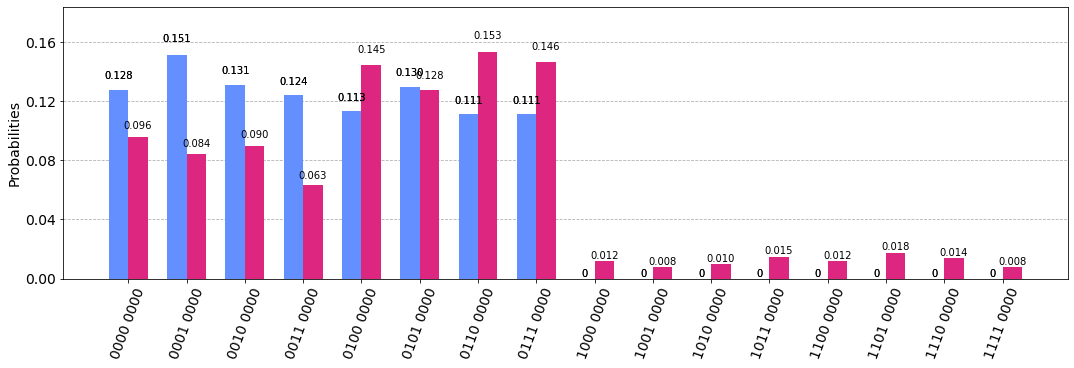

In [11]:
plot_histogram([sim_results, real_results], figsize=(18, 5))

As I highlighted for you before, this gate takes 12 CNOTs and 4 qubits even though we only need 3 qubits for our model.  This particular implementation of $U_{fh}$ that you have constructed is in fact not the smartest way one could implement this gate.  

In fac as Erik and Evan point out to me, you can perform the action of $U_{fh}$ without recourse to the ancilla qubit!  This reduces the CNOTs from $4!=12$ to $3!=6$.  For us, thats cutting our number of $CNOTs$ in half!  The in-situ circuit for $U_{fh}$ is:

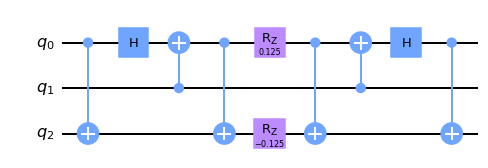

The tricky part, not easily show in this picture, is that the argument on $RZ$ on $q0$ is $\epsilon/4\times\eta$ and $RZ$ on $q2$ is $-\epsilon/4\times\eta$.

* Define this function as `fermion_hopping_opt2(epsilon,eta)`

In [12]:
def fermion_hopping_opt2(epsilon, eta):
    qc = QuantumCircuit(3)
    qc.cx(0, 2)
    qc.h(0)
    qc.cx(1, 0)
    qc.cx(0, 2)
    qc.rz((epsilon/4)*eta, 0)
    qc.rz((-epsilon/4)*eta, 2)
    qc.cx(0, 2)
    qc.cx(1, 0)
    qc.h(0)
    qc.cx(0, 2)
    
    lessgrossgate = qc.to_gate()
    lessgrossgate.name = "ufh2"
    return lessgrossgate

Better check you have properly implemented this with a decompose and a draw()

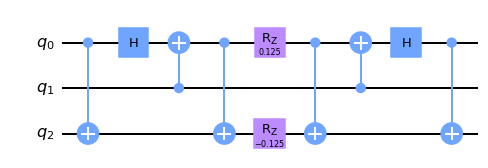

In [13]:
qc = QuantumCircuit(3)
qubitlist= [0,1,2]
lessgrossgate = fermion_hopping_opt2(epsilon, eta)
qc.append(lessgrossgate, qubitlist)
qc.decompose().draw()

Now, lets try and repeat the experiment of comparing the the simulated results to the real machine for a $|+++\rangle$ state.  Unlike the previous circuit, you don't need 4 qubits and 4 classical bits, but only 3 of each.

In [14]:
qc = QuantumCircuit(3, 3)
qubitlist = [0,1,2]
lessgrossgate = fermion_hopping_opt2(epsilon, eta)
qc.h(0)
qc.h(1)
qc.h(2)
qc.append(lessgrossgate, qubitlist)
qc.measure_all()

simbackend = Aer.get_backend("qasm_simulator")
transpiled = transpile(qc, backend=simbackend)
qobj = assemble(transpiled)
results = simbackend.run(qobj).result()
sim_results = results.get_counts()

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
backend = provider.get_backend('ibm_lagos')
print("backend: ", backend)

shots = 1024
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job, interval=2)
real_results = job.result().get_counts()

ibmqfactory.load_account:WARNING:2021-07-23 21:20:02,693: Credentials are already in use. The existing account in the session will be replaced.


backend:  ibm_lagos
Job Status: job has successfully run


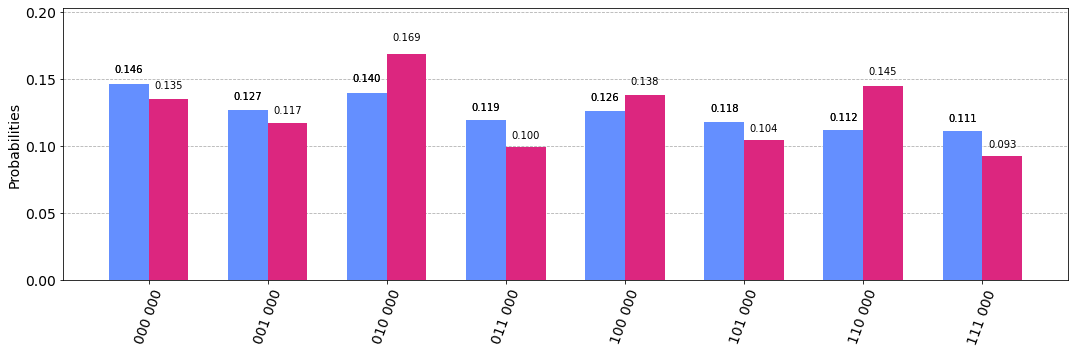

In [15]:
plot_histogram([sim_results, real_results], figsize=(18, 5))

In order to extract physics from this simulation, we need to take the qubits and convert them into a meaningful number.  For this lab, we are going to extract the mean electron number as a function of time.  To do this, define a function `get_mean_fermion_number(counts)` which takes in the dictionary of counts of a run and determines the mean number of electrons by counting the lowest qubit.  

In [16]:
#define your function to take in a dictionary counts
def get_mean_fermion_number(counts):
    #first define a variable mean and set to 0
    mean = 0
    #define a variable total_counts = sum(counts.values())
    total_counts = sum(counts.values())
    #perform a for loop over the elements in counts, using for example `s` as the loop variable
    for s in counts:
        #define a variable p which is the last element of the identifier in your loop variable
        #i.e. p = s[-1]
        p = s[-1]
        #check if p is a `1`.
        if p == '1':
            #if p == '1', then add to mean counts[s]/total_counts
            mean += counts[s]/total_counts
    #return the mean       
    return mean

In order to understand how badly we are doing with our real device results, we need to be computing some kind of statistical error bars, so that we can distinguish meaningful disagreement with the exact results from fluctuations from sampling.  To do this, we will employ the _bootstrap method_ which is similar to the replica method that you were introduced to long ago during the Monte Carlo lab.  Lets implement that next:

In [57]:
#define a function `get_bootstrap_error(counts)` which takes in a dictionary `counts`
def get_bootstrap_error(counts):
    #compute the nshots by using sum(counts.values())
    nshots = sum(counts.values())
    #For our statistics, we will resample the distribution 100 times, so set B=100
    B = 100
    #Extract the list of unique keys in your dictionary and store them as a variable k via
    # k = list(counts.keys())
    k = list(counts.keys())
    #For each key, we need to define a probability list prob via [counts[a]/nshots for a in k]
    prob = [counts[a]/nshots for a in k]
    #define an empty array means
    means = []
    #With all this setup, now perform a for loop over b in range(B)
    for b in range(B):
        #set a variable m=0
        m = 0
        #build a new set of samples using numpy.random.choice with the arguments k, size=nshots, and p=prob
        #this function will return nshots worth of new results with probability prob from the choices in k
        samples = np.random.choice(k, size=nshots, p=prob)
        #make a for loop over s in the list samples
        for s in samples:
            #set a new variable p = s[-1] to again extract the number of electrons
            p = s[-1]
            #check if p = `1`
            if p == '1':
                #add 1/nshots to m if true
                m += 1/nshots
        #append the results of m to means
        means.append(m)
    #return from the function the standard deviation of means via numpy.std(means)   
    return np.std(means)

At this point, you have created all of the functions you need to run the code and see how it works.  That will be in Part 3.